In [173]:
#imports

from typing import Callable
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from astropy.timeseries import LombScargle




# Data Generation

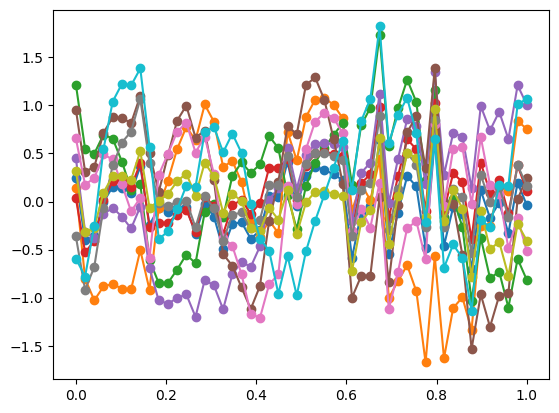

In [140]:
class Generate_Signal:

    def __init__(self,
      nsamples:int, npoints:int=50,
    ) -> None:
      
      self.nsamples = nsamples
      self.npoints = npoints

      pass

    def simplesin(self, phase, period):
      
      y = np.sin(phase*2*np.pi*period)
      
      return y

    def compositesin(self,
      phase:np.ndarray, periods, amplitudes
      ):

      # periods = np.random.rand(2)*4

      y = 0
      for n in range(periods.shape[1]):
        shift = np.random.randint(0, self.npoints)
        y_ = amplitudes[:,n].reshape(-1,1)*np.roll(np.sin(phase*2*np.pi*periods[:,n].reshape(-1,1)), shift=shift)
        y += y_


      return y#, periods

    def generate(self,
      func:Callable=None,
      noise:float=0.05,
      ):

      if func is None:
        # func = self.simplesin
        func = self.compositesin

      periods = np.random.rand(self.nsamples,2)*4
      amplitudes = np.random.rand(self.nsamples,2)*1

      x_out = np.array([np.linspace(0, 1, self.npoints) for i in range(self.nsamples)])
      y_out = func(x_out, periods, amplitudes)
      y_out += np.random.randn(self.npoints)*noise #add noise

      return x_out, y_out, periods

    def testplot(self,
      x:np.ndarray, y:np.ndarray             
      ):

      fig = plt.figure()
      ax1 = fig.add_subplot(111)
      for idx, (xi, yi) in enumerate(zip(x,y)):
        ax1.plot(xi, yi)

      plt.show()
      return


#%%main

nsamples = 100000
npoints = 50
GS = Generate_Signal(nsamples=nsamples, npoints=npoints)

x, y, p = GS.generate(func=None, noise=0.4)

X = np.empty((nsamples,npoints,2))
for iidx, (nx, ny) in enumerate(zip(x, y)):
  for jidx, (nxi, nyi) in enumerate(zip(nx, ny)):
    X[iidx, jidx] = np.array([nxi, nyi])


for i in range(10):
  # plt.scatter(X[i,:,0], X[i,:,1], s=1)
  plt.plot(X[i,:,0], X[i,:,1], 'o-')


# AI

In [141]:

print(X.shape, p.shape)

X_train, X_test, y_train, y_test = train_test_split(X, p, test_size=0.2)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(100000, 50, 2) (100000, 2)
(80000, 50, 2) (80000, 2)
(20000, 50, 2) (20000, 2)


In [143]:
import numpy as np
from keras.models import Model
from keras.layers import Input, LSTM, Dense

class BasicLSTM:
    def __init__(self, input_shape, hidden_units, output_units):
        self.input_shape = input_shape
        self.hidden_units = hidden_units
        self.output_units = output_units
        self.model = self.build_model()

    def build_model(self):
        # Define the input layer
        inputs = Input(shape=self.input_shape)

        # Add the LSTM layer
        x = LSTM(units=self.hidden_units)(inputs)

        # Add the output layer
        outputs = Dense(units=self.output_units, activation='relu')(x)

        # Create the model
        model = Model(inputs=inputs, outputs=outputs)
        return model

# Example usage
input_shape = (50, 2)  # Assuming input sequences of length 50 and 2 feature
hidden_units = 32  # Number of units in the LSTM layer
output_units = 2  # Number of output units

# Instantiate the BasicLSTM class
lstm_model = BasicLSTM(input_shape, hidden_units, output_units)

# Build and compile the model
model = lstm_model.build_model()
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, shuffle=True)

# Make predictions
predictions = model.predict(X_test)
print(predictions)


Model: "model_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_33 (InputLayer)       [(None, 50, 2)]           0         
                                                                 
 lstm_33 (LSTM)              (None, 32)                4480      
                                                                 
 dense_31 (Dense)            (None, 2)                 66        
                                                                 
Total params: 4,546
Trainable params: 4,546
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
2000/2000 [==============================] - 44s 21ms/step - loss: 0.7658 - accuracy: 0.6845 - val_loss: 0.6033 - val_accuracy: 0.7124
Epoch 2/5
2000/2000 [==============================] - 43s 21ms/step - loss: 0.4490 - accuracy: 0.7647 - val_loss: 0.4288 - val_accuracy: 0.7717
Epoch 3/5
2000/2000 [=========

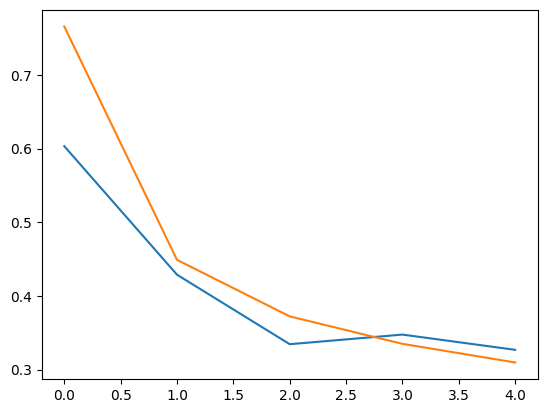

In [144]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

625/625 [==============================] - 5s 7ms/step
0.32004217999508033


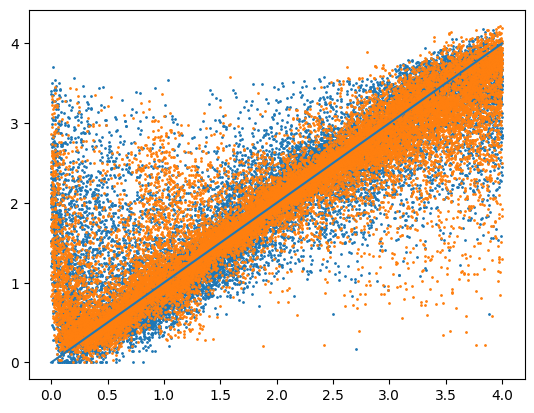

In [146]:

y_pred = model.predict(X_test)
print(mean_squared_error(y_test, y_pred))

plt.scatter(y_test[:,0], y_pred[:,0], s=1)
plt.scatter(y_test[:,1], y_pred[:,1], s=1)
plt.plot(np.linspace(0,4,100), np.linspace(0,4,100))




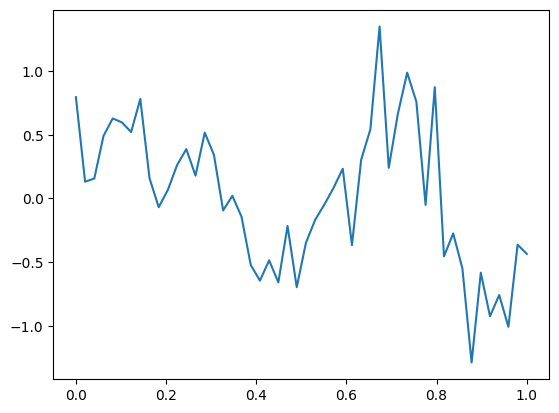

In [148]:
plt.plot(X_train[0,:,0], X_train[0,:,1])

1/1 [==============================] - 0s 47ms/step


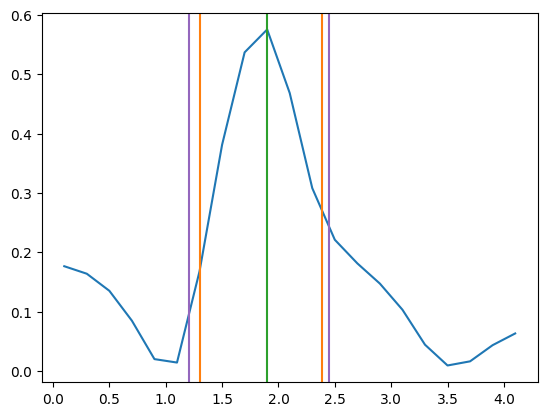

In [171]:
%matplotlib inline


LS = LombScargle(X_train[0,:,0], X_train[0,:,1])

freq, power = LS.autopower(minimum_frequency=0.1, maximum_frequency=4)

best_period_ls = freq[np.argmax(power)]
best_period_nn = model.predict(X_train[0].reshape(-1,50,2))

plt.plot(freq, power)
plt.axvline(y_train[0,0],   color='tab:orange')
plt.axvline(y_train[0,1],   color='tab:orange')
plt.axvline(best_period_ls, color='tab:green')
plt.axvline(best_period_nn[0,0], color='tab:purple')
plt.axvline(best_period_nn[0,1], color='tab:purple')

# plt.xlim(0,5)